<a href="https://colab.research.google.com/github/karanidenis/Ml_concepts/blob/main/Kikuyu_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This Notebook contains a model that translates a sentence from English to Kiswahili.

In [ ]:
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.utils import plot_model

In [ ]:
# English_statement = ["I am a boy"]
# Kiswahili_statement = ["Mimi ni kijana"]
English_statements = ["I am a boy", "I am a girl", "He is a man", "She is a woman"]
# Kikuyu_statements = ["Nie di mwanake", "Nie di mwiretu", "Ni muthuri", "Ni mutumia"]
Kikuyu_statements = ["Niû ndî mwanake", "niû ndî muirîtu", "Ûcio ni mûthuri", "Ûcio ni mutumia"]

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
# max sentence length
def max_length(lines):
 return max(len(line.split()) for line in lines)

In [ ]:
# prepare english  and Kikuyu tokenizer
eng_tokenizer = create_tokenizer(English_statements)
# print(eng_tokenizer)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print(eng_vocab_size)
eng_max_len = max_length(English_statements)
print(eng_max_len)

kyuk_tokenizer = create_tokenizer(Kikuyu_statements)
# print(kyuk_tokenizer)
kyuk_vocab_size = len(kyuk_tokenizer.word_index) + 1
print(kyuk_vocab_size)
kyuk_max_len = max_length(Kikuyu_statements)
print(kyuk_max_len)

11
4
9
3


In [ ]:
# Encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    sequences = tokenizer.texts_to_sequences(lines)
    return pad_sequences(sequences, maxlen=length, padding='post')

In [ ]:
# Prepare data
trainX = encode_sequences(eng_tokenizer, eng_max_len, English_statements)
print(trainX.shape)
trainY = encode_sequences(kyuk_tokenizer, kyuk_max_len, Kikuyu_statements)
print(trainY.shape)
trainY = to_categorical(trainY, num_classes=kyuk_vocab_size)
print(trainY.shape)


(4, 4)
(4, 3)
(4, 3, 9)


In [ ]:
# Define model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

# Hyperparameters
n_units = 256

# define model
model = define_model(eng_vocab_size, kyuk_vocab_size, eng_max_len, kyuk_max_len, n_units)

In [ ]:
# compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 256)            2816      
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 3, 9)              2313      
 ributed)                                                        
                                                                 
Total params: 1055753 (4.03 MB)
Trainable params: 105575

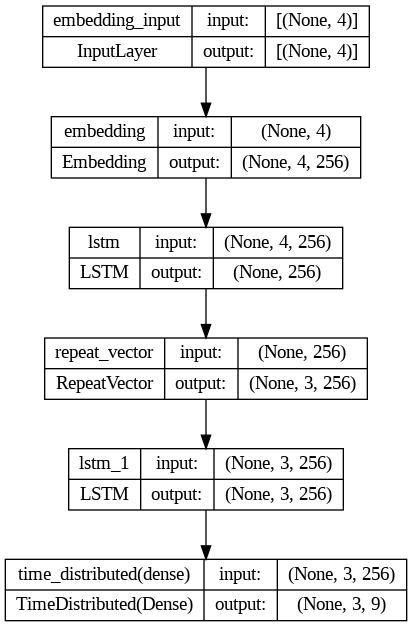

In [ ]:
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Train the model
model.fit(trainX, trainY, epochs=30, batch_size=64)


Epoch 1/30
1/1 [==============================] - 7s 7s/step - loss: 2.1971 - accuracy: 0.0833
Epoch 2/30
1/1 [==============================] - 0s 66ms/step - loss: 2.1882 - accuracy: 0.3333
Epoch 3/30
1/1 [==============================] - 0s 74ms/step - loss: 2.1785 - accuracy: 0.3333
Epoch 4/30
1/1 [==============================] - 0s 69ms/step - loss: 2.1670 - accuracy: 0.3333
Epoch 5/30
1/1 [==============================] - 0s 84ms/step - loss: 2.1530 - accuracy: 0.3333
Epoch 6/30
1/1 [==============================] - 0s 72ms/step - loss: 2.1351 - accuracy: 0.3333
Epoch 7/30
1/1 [==============================] - 0s 71ms/step - loss: 2.1123 - accuracy: 0.3333
Epoch 8/30
1/1 [==============================] - 0s 99ms/step - loss: 2.0831 - accuracy: 0.3333
Epoch 9/30
1/1 [==============================] - 0s 70ms/step - loss: 2.0457 - accuracy: 0.3333
Epoch 10/30
1/1 [==============================] - 0s 84ms/step - loss: 1.9981 - accuracy: 0.3333
Epoch 11/30
1/1 [==============

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# Function to decode sequences back to text
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def decode_sequence(sequence, tokenizer):
    return ' '.join([word_for_id(i, tokenizer) for i in sequence if i > 0])

# Predict translations for the given input sequences
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = decode_sequence(integers, tokenizer)
    return target

# Prepare input data
testX = encode_sequences(eng_tokenizer, eng_max_len, English_statements)

# Predict translations
predictions = []
for i in range(len(testX)):
    source = testX[i].reshape((1, testX.shape[1]))
    translation = predict_sequence(model, kyuk_tokenizer, source)
    predictions.append(translation)

# Print translations
for i in range(len(predictions)):
    print(f'English: {English_statements[i]}')
    print(f'Predicted Kikuyu: {predictions[i]}')
    print(f'Reference Kikuyu: {Kikuyu_statements[i]}')
    print()

# Calculate BLEU scores
smoothie = SmoothingFunction().method4
bleu_scores = []

for i in range(len(predictions)):
    reference = [Kikuyu_statements[i].split()]
    candidate = predictions[i].split()
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    bleu_scores.append(score)
    print(f'Sentence {i+1} BLEU score: {score:.4f}')

# Average BLEU score
average_bleu = np.mean(bleu_scores)
print(f'Average BLEU score: {average_bleu:.4f}')

English: I am a boy
Predicted Kikuyu: niû ndî mwanake
Reference Kikuyu: Niû ndî mwanake

English: I am a girl
Predicted Kikuyu: niû ndî muirîtu
Reference Kikuyu: niû ndî muirîtu

English: He is a man
Predicted Kikuyu: ûcio ni mûthuri
Reference Kikuyu: Ûcio ni mûthuri

English: She is a woman
Predicted Kikuyu: ûcio ni mutumia
Reference Kikuyu: Ûcio ni mutumia

Sentence 1 BLEU score: 0.2118
Sentence 2 BLEU score: 0.5757
Sentence 3 BLEU score: 0.2118
Sentence 4 BLEU score: 0.2118
Average BLEU score: 0.3028
